In [4]:
import matplotlib.pyplot as plt
from pdf2image import convert_from_path

In [5]:
def display(img):
  # for i, page_img in enumerate(pages):
  plt.figure(figsize=(8, 10))
  plt.imshow(img)
  plt.axis('off')
  plt.show()



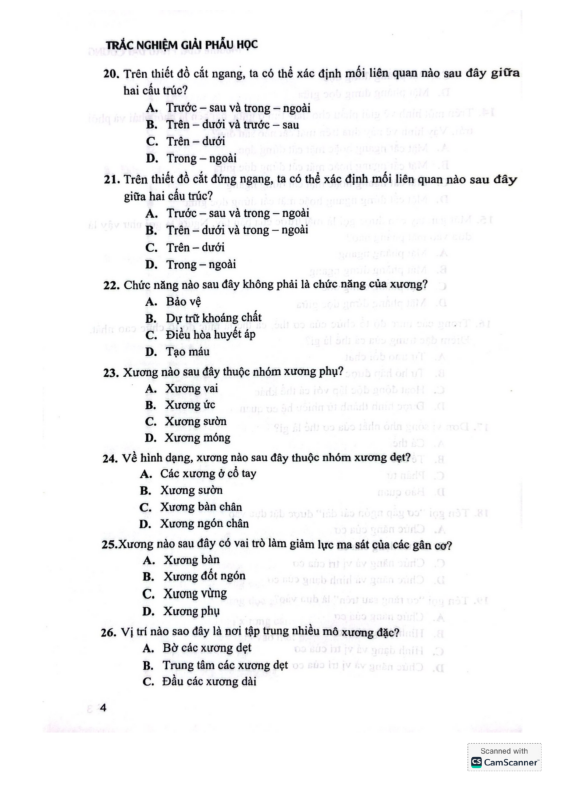

In [6]:
pdf_path = "./input/Module GPDC-2.pdf"
pages = convert_from_path(pdf_path)
display(pages[3])


In [7]:
import numpy as np
import cv2

temp_img = pages[0]
temp_img_2 = pages[7]

first_page = np.array(temp_img)
second_page = np.array(temp_img_2)
print(type(first_page))

<class 'numpy.ndarray'>


# Crop the header

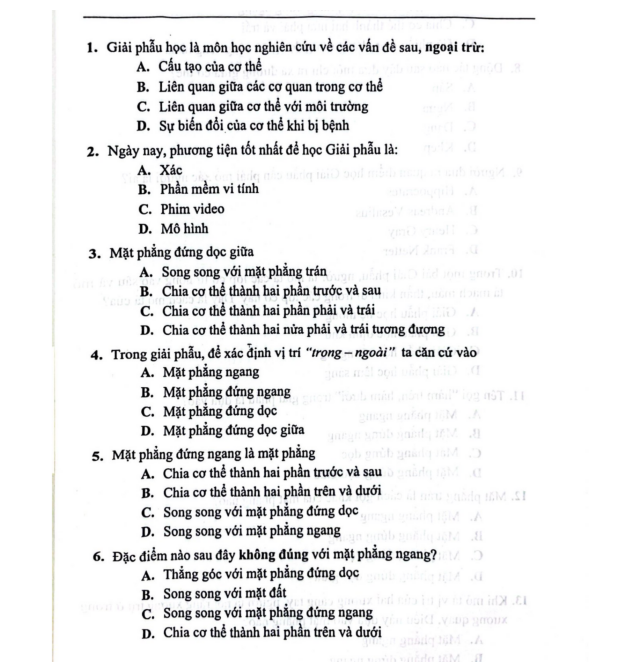

In [8]:
# first_page is a NumPy array representing the image
header_height = 300  # pixels to remove from the top
footer_height = 300  # pixels to remove from the bottom

first_page = first_page[header_height:-footer_height, :, :]
display(first_page)

# Crop the second page

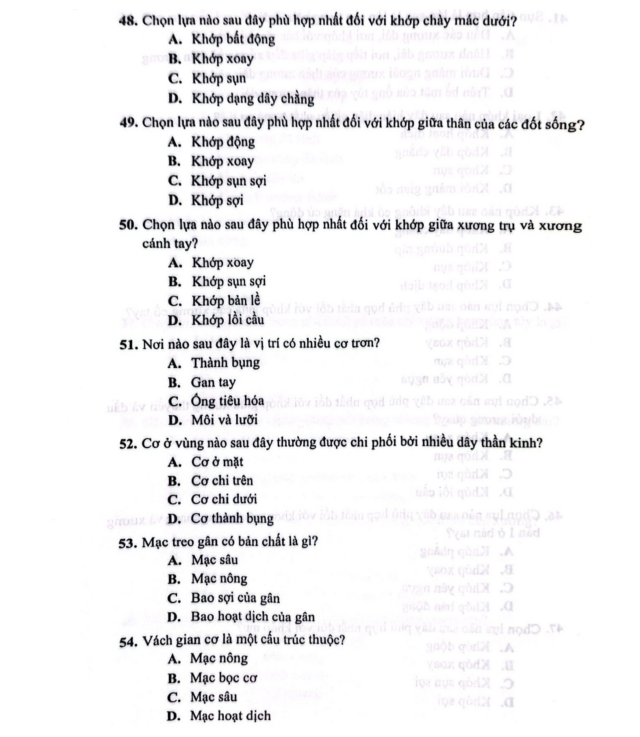

In [9]:
# first_page is a NumPy array representing the image
header_height = 175  # pixels to remove from the top
footer_height = 250  # pixels to remove from the bottom

second_page = second_page[header_height:-footer_height, :, :]
display(second_page)

# Dilation and Threshold

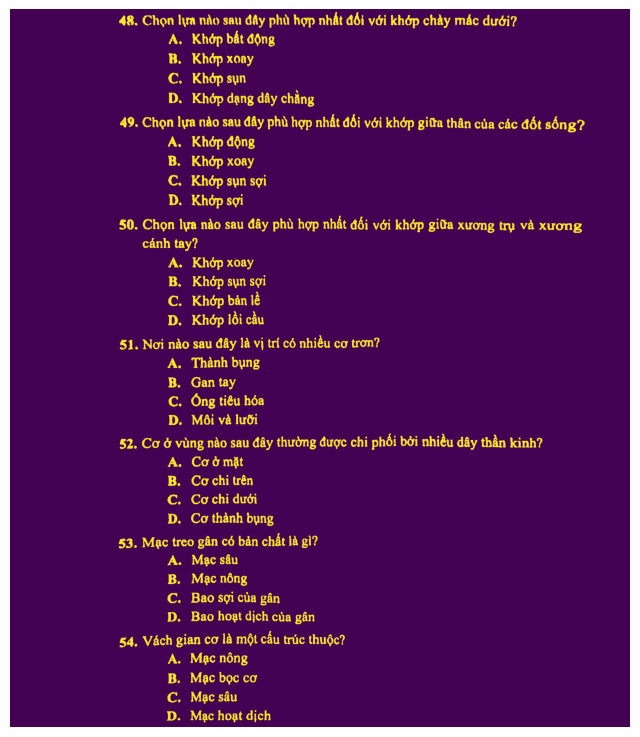

In [10]:
gray = cv2.cvtColor(second_page, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

display(thresh)

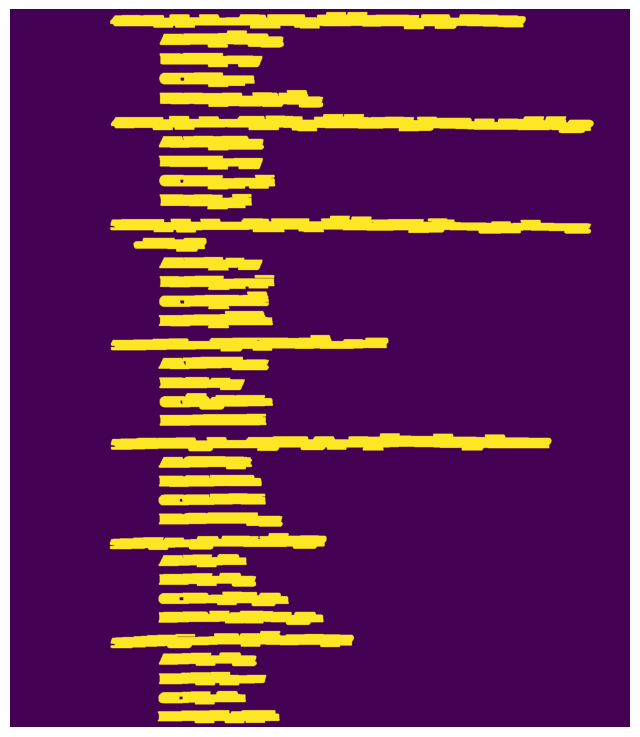

In [11]:
# 3. Dilation
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 2))
dilate = cv2.dilate(thresh, kernel, iterations=2)
display(dilate)


In [12]:
contours, _ = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
blocks = []
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if h > 28 and w > 60: 
        roi = second_page[y:y+h, x:x+w]
        blocks.append((y, roi))

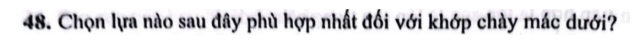

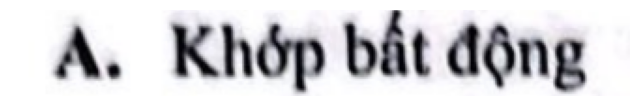

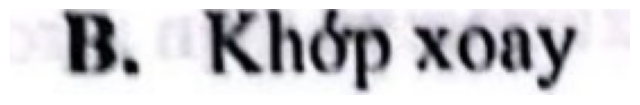

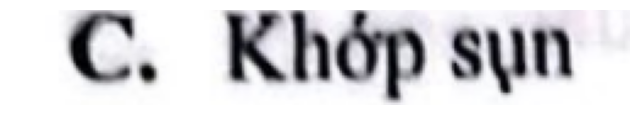

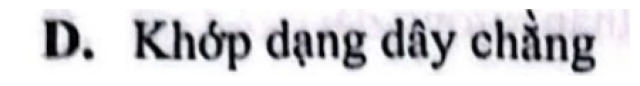

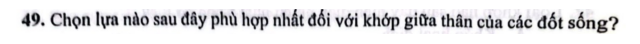

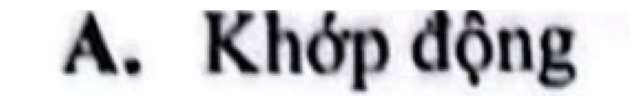

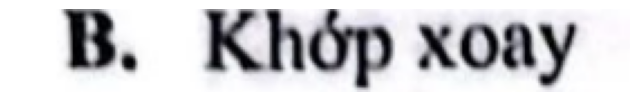

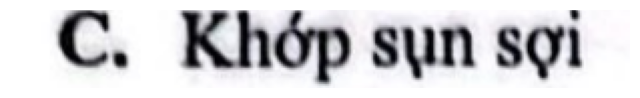

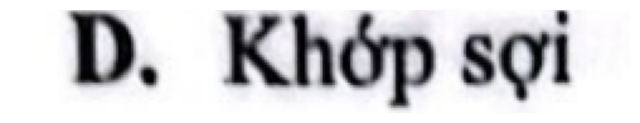

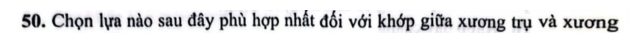

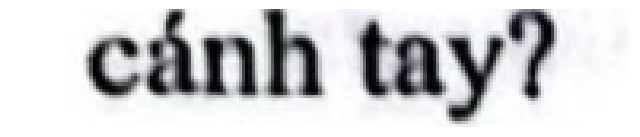

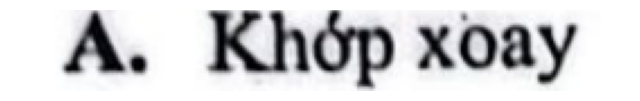

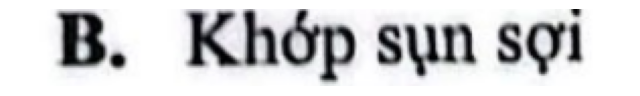

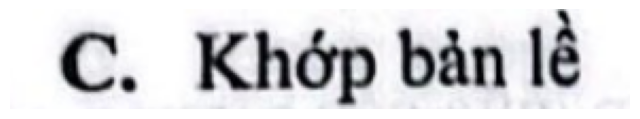

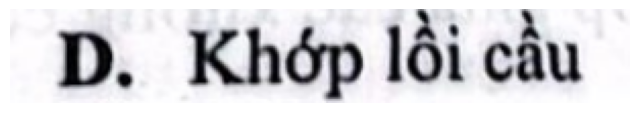

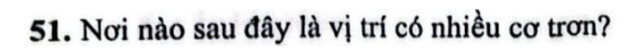

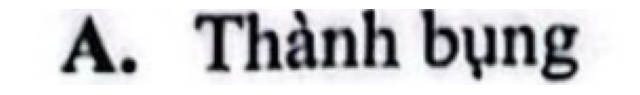

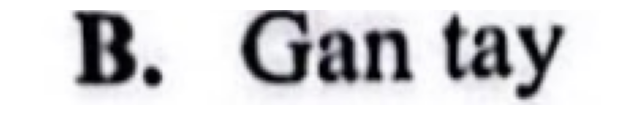

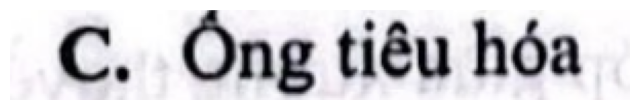

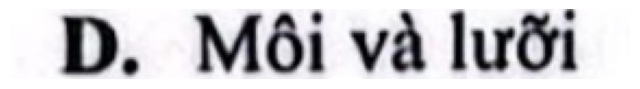

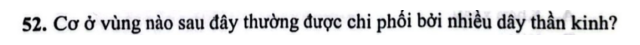

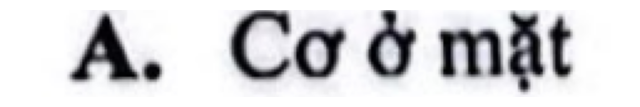

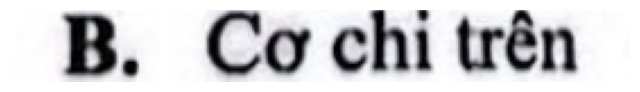

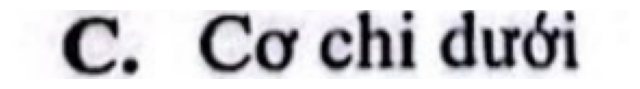

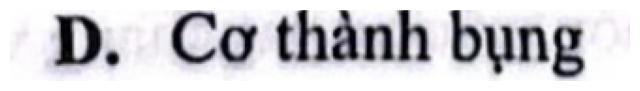

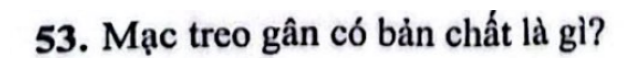

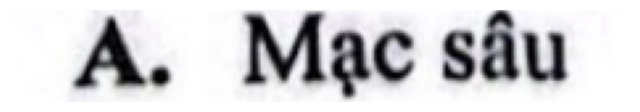

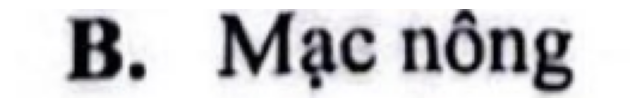

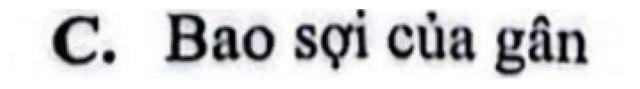

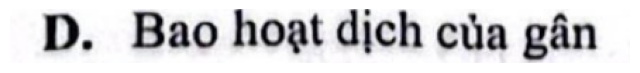

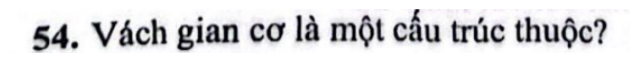

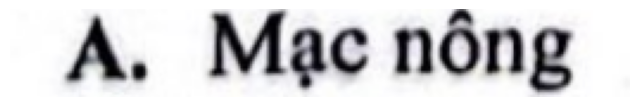

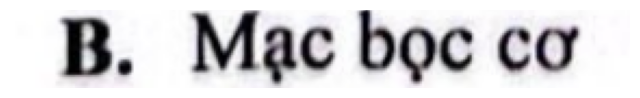

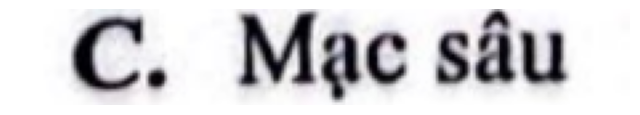

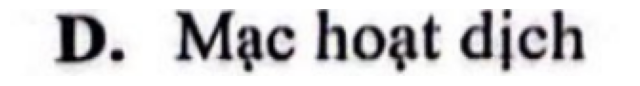

In [13]:
blocks = sorted(blocks, key=lambda b: b[0])
for _, roi in blocks:
    if roi.size > 0:
        display(roi)

# OCR processing

In [ ]:
import pytesseract
from pprint import pprint
config = "--oem 1 --psm 7 -l vie"

data = []

for _, roi in blocks:
    roi = cv2.resize(roi, None, fx=4, fy=4, interpolation=cv2.INTER_LANCZOS4)
    text = pytesseract.image_to_string(roi, config=config)
    text = text.replace("\n", " ")
    text = text.replace("ŒC.", "C.")
    text = text.replace("Œ.", "C.")
    text = text.replace("Á.", "A.")
    text = text.replace("€C.", "C.")
    text = text.replace("_ _D.", "D.")
    text = text.replace("B,", "B.")

    data.append(text)

pprint(data)

['48. Chọn lựa nào sau đây phù hợp nhất đối với khớp chày mác đưới? ',
 'A. Khớp bất động ',
 'B. Khớp xoay ',
 'C. Khớp sụn ',
 'D.. Khớp dạng dây chẳng ',
 '49. Chọn lựa nào sau đây phù hợp nhất đôi với khớp giữa thân của các đốt '
 'sống? ',
 'A. Khớp động ',
 'B. Khớp xoay ',
 'C. Khớp sụn sợi ',
 'D. Khớp sợi ',
 '50. Chọn lựa nào sau đây phù hợp nhật đối với khớp giữa xương trụ và xương ',
 'cảnh tay? ',
 'A. Khớp xoay ',
 'B. Khớp sụn sợi ',
 'C. Khớp bản lề ',
 'D. Khớp lôi cầu ',
 '51. Nơi nào sau đây là vị trí có nhiêu cơ trơn? ',
 'A. Thành bụng ',
 'B, Gan tay ',
 'C. Ông tiêu hóa ',
 'D. Môi và lưỡi ',
 '52. Cơ ở vùng nào sau đây thường được chỉ phôi bởi nhiều dây thần kinh? ',
 'A. Cơ ở mặt ',
 'B. Cơ chi trên ',
 'C. Cơ chi dưới ',
 'D. Cơ thành bụng ',
 '53. Mạc treo gân có bản chất là gì? ',
 'A. Mạc sâu ',
 'B. Mạc nông ',
 'C. Bao sợi của gân ',
 'D. Bao hoạt dịch của gân ',
 's4. Vách gian cơ là một câu trúc thuộc? ',
 'A. Mạc nông ',
 'B. Mạc bọc cơ ',
 'C. Mạc sâu

# Save in structure Fields

In [12]:
def is_answer(line):
  options = ['A.', 'B.', 'C.', 'D.']
  return any(opt in line for opt in options)

In [ ]:
import json
import re

questions = []
i = 0

while i < len(data):
    line = data[i].strip()


    if re.match(r"^\d+\.", line):
        question_lines = [line]
        i += 1

        # Gom các dòng tiếp theo cho đến khi gặp "A."
        while i < len(data) and not data[i].strip().startswith("A."):
            question_lines.append(data[i].strip())
            i += 1

        question_text = " ".join(question_lines)

        # Lấy 4 đáp án
        options = {}
        for opt in ["A.", "B.", "C.", "D."]:
            if i < len(data) and data[i].strip().startswith(opt):
                options[opt[0]] = data[i].strip()
                i += 1
            else:
                options[opt[0]] = ""  # phòng trường hợp thiếu đáp án

        # Lưu vào list
        questions.append({
            "Question": question_text,
            **options
        })
    else:
        i += 1  # bỏ qua dòng không phải câu hỏi

# Xuất ra file JSON
with open("questions_sample.json", "w", encoding="utf-8") as f:
    json.dump(questions, f, ensure_ascii=False, indent=2)

print("✅ Saved to questions.json")


✅ Saved to questions.json


# Altering Coordinates

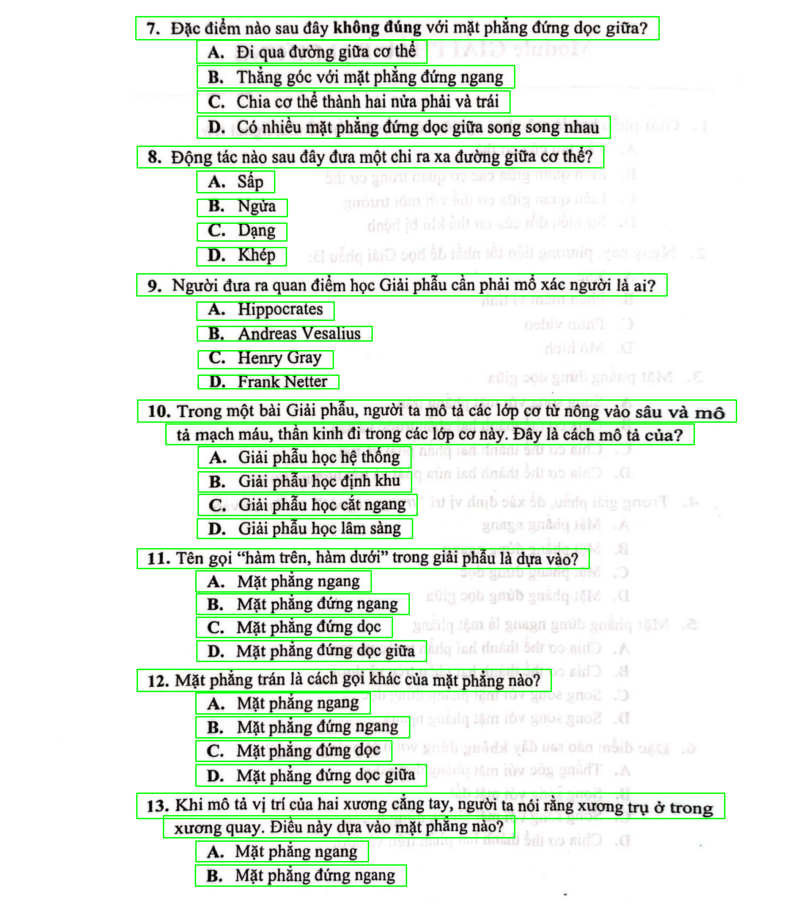

In [27]:
img_bbox = second_page.copy()

for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if h > 28 and w > 60:   # lọc noise
      cv2.rectangle(img_bbox, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.figure(figsize=(10, 12))
plt.imshow(cv2.cvtColor(img_bbox, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()